In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

In [3]:
# set raw file path
path = './advertising_files/PP Cerebro Competitor ASIN Search Terms.xlsx'

# set output path
output_path = './output/'

## Data Preparation

### Import Data and Create the Combined DataFrame

In [4]:

# Import the Excel file, extract the sheets and create individual and combined DataFrames
data = {}
data['sheets'] = [] #this will serve as a quick reference of sheet names and later column names
data['combined'] = pd.DataFrame() #combined df starts out as empty df, populated below
data_list = []
with pd.ExcelFile(path) as xls:
    for sheet in xls.sheet_names:
        name = sheet[21:] #Keeping only the ASIN as the name
        data['sheets'].append(name) #add the name of the current sheet as an element to the sheets list
        data[name] = pd.read_excel(xls,sheet,header=1) # read the Excel sheet
        # clean column names
        data[name].columns = data[name].columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
        # keep only relevant columns
        data[name] = data[name][['phrase','search_volume','organic_rank']]
                
        # create the combined list, merging phrase and corresponding keyword volumes from all lists, without duplicates
        if data['combined'].empty:
            # check whether data['combined'] exists; if not, create
            data['combined'] = (data[name]
                                .rename(columns = {'organic_rank':name})                           )
        else:
            # if exists, merge 
            data['combined'] = (
                pd.merge(
                    data['combined'],
                    (data[name]
                     .rename(columns={'organic_rank': name})),
                    how='outer',
                    on =['phrase','search_volume']
                )
            )

# replace non-numeric values with None for in all numeric rows (search_volume and ranks)
numeric_columns = [column for column in data['combined'].columns[1:]]
data['combined'][numeric_columns] = data['combined'][numeric_columns].applymap(lambda x: x if np.isreal(x) else None)

# Convert all numeric rows to numeric values
data['combined'][numeric_columns] = data['combined'][numeric_columns].applymap(pd.to_numeric)

# for testing
data1 = data['B00H2ZS5VM'].copy()
data2 = data['B00H2ZS5VM'].copy()

### Create a Relevance Score

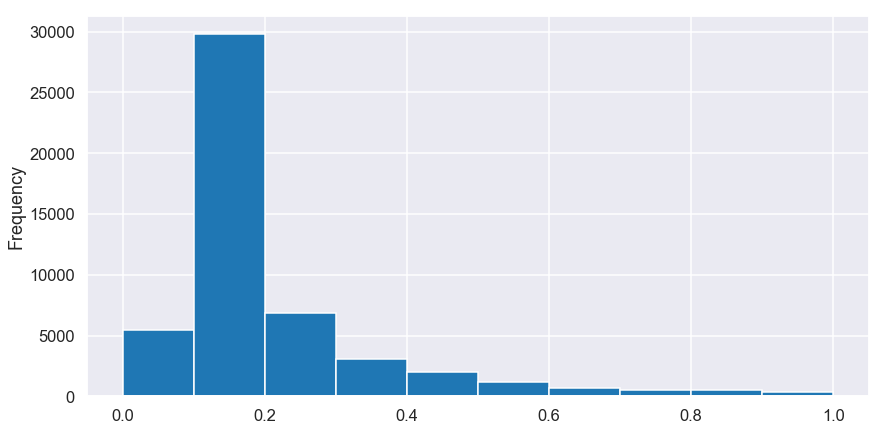

In [17]:
def relevance(df, cutoff = 20):
    """assign a relevance based on the cutoff
    input: dataframe with only the rows of rankings,
    cutoff (optional) integer
    output: score float"""
    
    sheets = [sheet for sheet in df.columns]    
    # relevance is the sum of ranks greater than cutoff for each keywords
    relevance = 0 #relevance starts at 0 then we add to it as we find ASINs with rank below the cutoff
    for sheet in sheets:
        relevance += (df[sheet] <= cutoff)
    relevance = relevance / len(sheets) #divide by number of ASINs to get a percentage
    return relevance

# set the cutoff based on analysis, below
cutoff = 500
# create 'relevance' column using the desired cutoff
data['combined']['relevance'] = relevance(data['combined'][data['sheets']],cutoff)
# create 'relevant_volume' column as a proxy for volume that is relevant to the product
data['combined']['relevant_volume'] = data['combined'].search_volume * data['combined'].relevance


# plot distribution of relevance at desired cutoff
ax1 = data['combined'].relevance.plot.hist(figsize=(14,7))

## Create Ad Group
Levels are based on the exploration done in subsequent sections (see below)

In [6]:
# function to create an arbitrary number of levels based on cutoffs
def create_levels(df,levels):
    """ 
    Recursive function that outputs level. Note that levels will be processed in order. The algorithm will accept the first matching level
    input: df with ['relevance',search_volume]
    level (list) in order of smallest to largest level in the form [LEVEL_NAME,CUTOFF_MIN_RANK, CUTOFF_MIN_VOLUME]
    the last element of the list shoudl be a str label for the 'all else' category
    output: pandas series of len equal to input df, indicates level of each phrase
    """

    level = levels[0]
    if len(levels) <= 1:
        return levels[0]
    elif (df['relevance'] > level[1]) & (df['search_volume'] > level[2]):
        return level[0]
    else:
        return create_levels(df,levels[1:])

### Set Levels and Create ad_group column

In [ ]:


levels = [
    ['Level_1',0.8,895],
    ['Level_2',0.8,210],
    ['Level_3',0.9,770],
    ['Level_4',0.6,230],
    'Kitchen Sink'
]

data['combined']['ad_group'] = data['combined'].apply(create_levels,axis=1,args=([levels]))

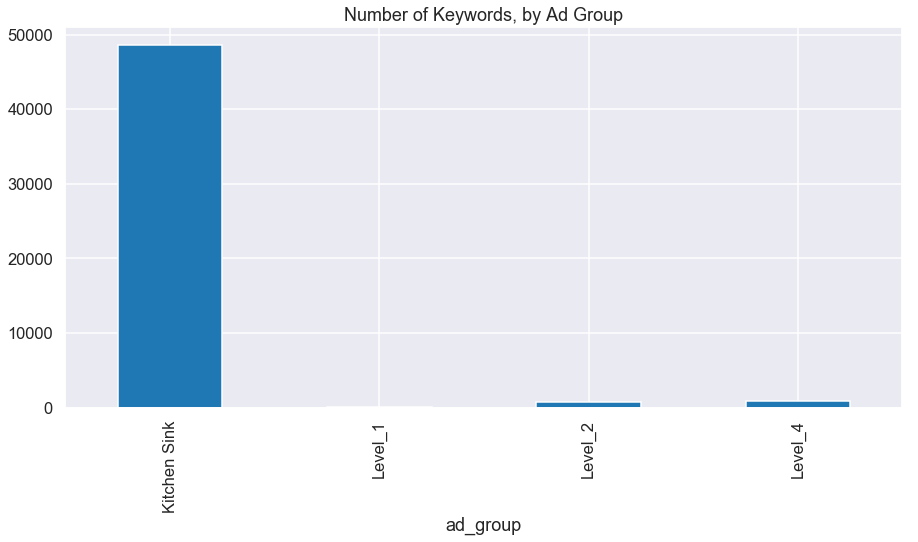

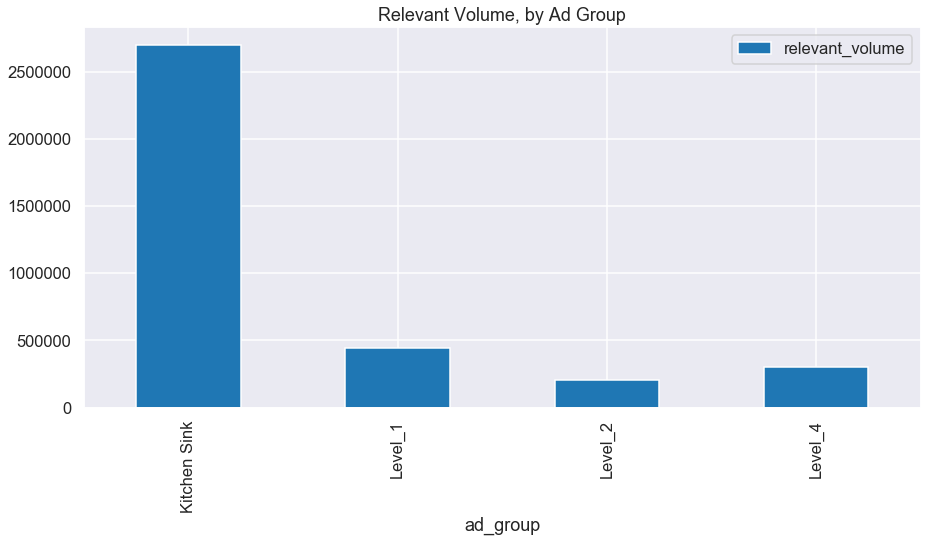

In [22]:
# Show Ad Group Size based on current levels
ax1 = (
    data['combined'][
        data['combined'].ad_group != 'Kitchen Sink '  # have added an extra space so that it does not omit Kitchen Sink
    ]
    .groupby(by=['ad_group'])
    .size()
).plot(kind = 'bar', figsize=(15,7),title='Number of Keywords, by Ad Group')


ax1 = (
    data['combined'][
        data['combined'].ad_group != 'Kitchen Sink '  # have added an extra space so that it does not omit Kitchen Sink
    ]
    .groupby(by=['ad_group'])
    [['relevant_volume']]
    .sum()
).plot(kind = 'bar', figsize=(15,7),title='Relevant Volume, by Ad Group')

## Export DataFrame to Excel

In [8]:
# list of ad_groups
ad_groups = [group for group in data['combined']['ad_group'].value_counts().index]

# Create an ExcelWriter object for writing an Excel with multiple sheets
with pd.ExcelWriter(output_path + 'output.xlsx') as writer:
    # create one sheet will all data
    data['combined'].to_excel(writer,sheet_name='all_data')
    # create one sheet per ad_group
    for ad_group in ad_groups:
        (
            data['combined'][
                data['combined'].ad_group == ad_group
            ]
            .sort_values(by=['relevance','search_volume'],ascending=False)
        ).to_excel(writer, sheet_name=ad_group)

# Exploratory Data Analysis

## Finding the right Rank Cutoff

### View Relevance distribution at various rank cutoffs

Eventually used cutoff of rank = 500 to assign relevance score. The higher cutoff more evenly distributes relevance scores. In a later step we will group phrases into Ad Groups using ranges of relevance and search volume

In [9]:
# See relevance distribution at various rank cutoffs
cutoffs = [10,20,30,50,100,200,500,1000,2000]
relevance_df, temp_df = pd.DataFrame, pd.DataFrame
df_temp = data['combined'].copy()

for cutoff in cutoffs:
    df_temp['relevance'] = relevance(data['combined'][data['sheets']], cutoff)
    # create a df of relevance and number of phrases that have that reelvance
    df_temp_2 = (df_temp
        .groupby(by = 'relevance')
        .size()
        .reset_index(level=0)
        .rename(columns = {0: 'cutoff_' + str(cutoff)})
             )

    # create the combined list
    if relevance_df.empty:
        # check whether data['combined'] exists; if not, create
        relevance_df = df_temp_2
    else:
        # if exists, merge 
        relevance_df = (
            pd.merge(
                relevance_df,
                df_temp_2,
                how='outer',
                on ='relevance'
                )
            )


We see here that a higher cutoff more evenly distributes relevance score and reduces the clump at relevance == 0

,relevance,cutoff_10,cutoff_20,cutoff_30,cutoff_50,cutoff_100,cutoff_200,cutoff_500,cutoff_1000,cutoff_2000
0,0.000000,47795.0,45594.0,43767.0,40060.0,31648,17947,5420,5420,5420
1,0.111111,1975.0,3495.0,4680.0,7262.0,13026,21998,29817,29817,29817
2,0.222222,469.0,840.0,1144.0,1613.0,2842,4945,6876,6876,6876
3,0.333333,91.0,287.0,435.0,714.0,1283,2240,3055,3055,3055
4,0.444444,19.0,95.0,207.0,329.0,662,1313,1961,1961,1961
5,0.555556,4.0,36.0,85.0,223.0,337,655,1170,1170,1170
6,0.666667,NaN,6.0,30.0,113.0,294,486,675,675,675
7,0.777778,NaN,NaN,5.0,33.0,205,373,521,521,521
8,0.888889,NaN,NaN,NaN,6.0,55,314,543,543,543
9,1.000000,NaN,NaN,NaN,NaN,1,82,315,315,315


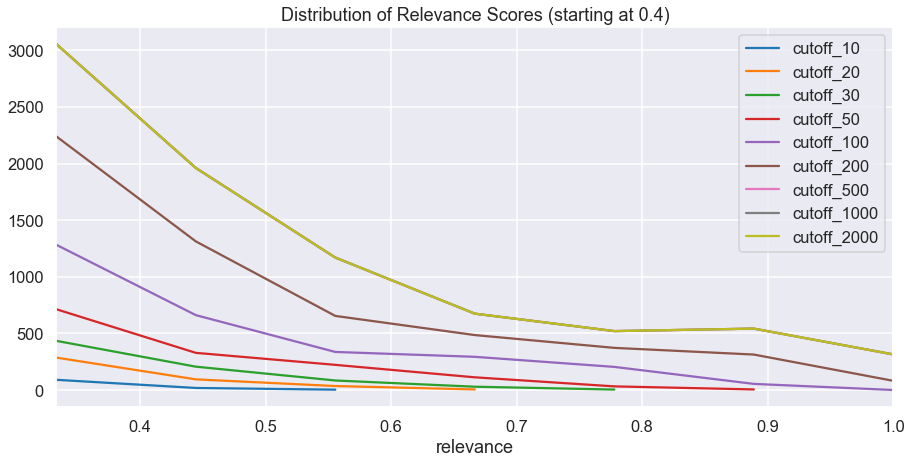

In [14]:
# plot the results
relevance_df[
    relevance_df.relevance > 0.3
].plot(
    x='relevance', y=['cutoff_'+str(cutoff) for cutoff in cutoffs],
    logy=False,figsize=(15,7),kind='line',title='Distribution of Relevance Scores (starting at 0.4)')
relevance_df

### See Samples of words at various relevance levels

In [16]:
# set various cutoffs and levels of relevance to show
cutoff, show_greater_than = 500, 0.9 # rank cutoff to use to create relevance score and relevance score cutoff
search_volume_cutoff = 1000 #minimum cutoff of search_volume
show_rows = 1000 # number of rows to show
data_test = data['combined'].copy()


# level_1 = [0.9,1000] # relevance > 0.9 & volume > 1000
# level_2 = [0.9,0] # relevance > 0.9 & no minimum volume
# level_3 = 


pd.set_option('display.max_rows', show_rows+1) # temporarily increase the number of rows shown in jupyter

data_test['relevance'] = relevance(data['combined'][data['sheets']], cutoff)

(
    data_test[
            (data_test.relevance > show_greater_than)
            &
            (data_test.search_volume <= search_volume_cutoff)
    ]
    .sort_values(by = ['relevance','search_volume'], ascending = False)
).head(show_rows)
# data1.sort_values()

,phrase,search_volume,B00H2ZS5VM,B014S96C9G,B018LH5FD0,B00CV9ICIA,B000H0ZJHW,B00K5REZ68,B06WLH9KJK,B00JAEKHOG,B001HBBQKY,relevance,ad_group
959,dog treats organic,896.0,42.0,295.0,6.0,15.0,50.0,8.0,44.0,234.0,80.0,1.0,Level_1
2501,chicken treats for dogs,894.0,106.0,1.0,220.0,21.0,32.0,71.0,56.0,86.0,194.0,1.0,Level_2
2004,training treats for dogs,771.0,84.0,264.0,133.0,42.0,1.0,115.0,45.0,26.0,14.0,1.0,Level_2
273,organic dog treats for large dogs,770.0,14.0,115.0,17.0,47.0,52.0,8.0,106.0,274.0,114.0,1.0,Level_2
636,dog treats large,770.0,30.0,45.0,33.0,46.0,16.0,47.0,39.0,204.0,107.0,1.0,Level_2
3716,dog treats small,770.0,158.0,242.0,42.0,28.0,2.0,73.0,24.0,45.0,57.0,1.0,Level_2
4070,dog treat bags,770.0,172.0,219.0,80.0,164.0,18.0,269.0,260.0,114.0,110.0,1.0,Level_2
6438,chewy dog treats,770.0,269.0,249.0,140.0,40.0,82.0,41.0,23.0,64.0,68.0,1.0,Level_2
7222,training treats for small dogs,770.0,305.0,107.0,39.0,86.0,1.0,88.0,27.0,24.0,9.0,1.0,Level_2
179,all natural dog treats,759.0,9.0,137.0,19.0,96.0,3.0,2.0,49.0,217.0,104.0,1.0,Level_2


### the issue is my merge. I do not add the search_volume when I perform the merge

1. fix the merge
 - might be fixed now

2. Fix the np.isreal
 - fixed: before I had the map lambda as part of the for loop so probably I was creating different values of phrase,search_volume

3. Check = search volume should have limited null values. These should be equally distributed among 
 - compare data['combined'].info() with a version filtered for search_volume.notnull()
 
4. Do isnumeric

5. Get the Relevance score

Continue onto the calculation

6. Create formula to get Ad Group - done

7. Export to CSV - done

8. Decide actual cutoffs


What is the calculation?



### Error Checking

Checking phrases where search volume is blank. Is the proportion the same in the combined list as in the other? Look at the rows in the combined list

In [101]:
# checking proportion of search_volume that is a real number
# looks OK
real_vs_total = []
real_vs_total.append(
    [
        data['combined'][data['combined'].search_volume.map(np.isreal)].search_volume.size,
        data['combined'].search_volume.size,
    ])


for sheet in data['sheets']:
    real_vs_total.append(
    [
        data[sheet][data[sheet].search_volume.map(np.isreal)].search_volume.size,
        data[sheet].search_volume.size
    ])
    
print(real_vs_total)

[[50353, 50353], [9801, 10057], [3959, 4558], [9187, 11222], [9072, 10726], [10997, 11125], [5442, 6405], [8536, 8893], [4576, 5315], [20833, 20996]]


In [102]:
# gets one aspect of a missing value
missing_values = []
for sheet in data['sheets']:
    missing_values.extend(data[sheet][~(data[sheet].search_volume.map(np.isreal))].phrase)

data['combined'][
    data['combined'].phrase.map(lambda x: x in missing_values[:3])
]

,phrase,search_volume,B00H2ZS5VM,B014S96C9G,B018LH5FD0,B00CV9ICIA,B000H0ZJHW,B00K5REZ68,B06WLH9KJK,B00JAEKHOG,B001HBBQKY
7781,all american gourmet jerky treats,NaN,NaN,NaN,65.0,24.0,NaN,22.0,NaN,NaN,NaN
8534,roxie treats,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8550,rocco roxie jerky treats,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
